# Train-test split and sampling

In [1]:
import pandas as pd

total= pd.read_excel('Train_test_data/Audio_features_selfrep.xlsx')

In [2]:
test_ids= ['9696-18','9702-04','9699-28','9699-39']

train= total.loc[total['child_ID'].isin(test_ids)== False]
test= total.loc[total['child_ID'].isin(test_ids)== True]

In [3]:
print(f'Shape of the train set before sampling: {train.shape}')
print(f'Shape of the test set: {test.shape}')

Shape of the train set before sampling: (99232, 12)
Shape of the test set: (13972, 12)


In [4]:
print(f"""
Class distribution in train set before sampling:
{train['gs_label'].value_counts()}""")


Class distribution in train set before sampling:
non-repetitive    97600
repetitive         1632
Name: gs_label, dtype: int64


In [5]:
ratio_train= train.loc[train['gs_label']=='repetitive'].shape[0]/ train.shape[0]

print(f"""
Ratio of repetitive utterance pairs in train set before sampling:
{ratio_train}""")


Ratio of repetitive utterance pairs in train set before sampling:
0.016446307642695904


In [6]:
print(f"""
Class distribution in test set:
{test['gs_label'].value_counts()}""")


Class distribution in test set:
non-repetitive    13811
repetitive          161
Name: gs_label, dtype: int64


In [7]:
ratio_test= test.loc[test['gs_label']=='repetitive'].shape[0] / test.shape[0]

print(f"""
Ratio of repetitive utterance pairs in test set:
{ratio_test}""")


Ratio of repetitive utterance pairs in test set:
0.011523046092184368


In [9]:
X_train_total= train.loc[:,'DTW_mfcc': 'DTW_combined']
X_test= test.loc[:,'DTW_mfcc': 'DTW_combined']

In [10]:
y_train= train['gs_label']
y_test= test['gs_label']

In [11]:
# Step 1: Random Undersampling of the 'non-repetitive' class in the train set
# Step 2: Oversampling of 'repetitive' class in the train set, undersampling of 'non-repetitive' class by ENN
from imblearn.combine import *
from imblearn.under_sampling import *
RU= RandomUnderSampler(sampling_strategy=0.15)
X_train_total, y_train= RU.fit_resample(X_train_total, y_train)
print(f"""
Class distribution in train set after random undersampling: 
{y_train.value_counts()}""")

SE= SMOTEENN(sampling_strategy= 0.6)
X_train_total, y_train= SE.fit_resample(X_train_total, y_train)
print(f"""
Class distribution in train set after random undersampling + under-oversampling with SMOTE-ENN: 
{y_train.value_counts()}""")


Class distribution in train set after random undersampling: 
non-repetitive    10880
repetitive         1632
Name: gs_label, dtype: int64

Class distribution in train set after random undersampling + under-oversampling with SMOTE-ENN: 
non-repetitive    6623
repetitive        5096
Name: gs_label, dtype: int64


In [12]:
print(f"""
Rows in the train set after sampling: {X_train_total.shape[0]}"")


Rows in the train set after sampling: 11719


In [13]:
ratio_train_total=y_train.value_counts()[1]/y_train.shape[0]
print(f"""
Ratio of repetitive utterance pairs in sampled train set:
{ratio_train_total}""")


Ratio of repetitive utterance pairs in sampled train set:
0.4348493898796826


In [27]:
train= pd.concat([X_train_total, y_train], axis=1)

In [29]:
#train.to_excel('Train_test_data/Full_train_selfrep.xlsx')

# Training and evaluation

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, datasets
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [3]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_selection import SelectKBest

def get_best_params(model_kind, n_splits=10, param_grid=None, features=None, positive_class='repetitive'):
    """Takes as input a classifier object, the parameter grid for a GridSearch, a nested list of feature sets and
    the positive class of the classification task,
    performs nested stratified cross validation (outer folds: 10, inner folds:2),
    and returns a dictionary containing the best combination of parameters and feature sets (from F1-score),
    the (two) most informative features and the maximum score obtained (= with the best parameters and feature sets,
    and the averaged F1-score over the two inner folds of the best outer fold)    
    """
    
    
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    best_params_list = []
    all_avg_scores = []

    for fold_idx, (train_index, test_index) in enumerate(skf.split(X_train_total, y_train)):  # outer CV loop
        X_train, X_test = X_train_total.iloc[train_index], X_train_total.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        best_params_fold = {}

        for feature_set_idx, feature_set in enumerate(features):  # loop through different feature sets
            X_train_subset = X_train.loc[:, feature_set]
            nested_skf = StratifiedKFold(n_splits=2, shuffle=True)

            avg_score = 0  # initialize average f1-score for this feature set
            best_score = -1  # initialize best score for comparison
            best_params = None  # initialize best parameters for the model

            for nested_train_index, nested_test_index in nested_skf.split(X_train_subset, y_train_fold):  # inner CV loop
                X_train_nested, X_val = X_train_subset.iloc[nested_train_index], X_train_subset.iloc[nested_test_index]
                y_train_nested, y_val = y_train_fold.iloc[nested_train_index], y_train_fold.iloc[nested_test_index]
                
                 # Perform feature selection
                if len(feature_set)==1:
                    k_features=1
                else:
                    k_features=2
                selector = SelectKBest(k=k_features)  
                selector.fit(X_train_nested, y_train_nested)

                # Train model
                f1_scorer = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=positive_class))
                model = GridSearchCV(model_kind, param_grid=param_grid, cv=2, scoring=f1_scorer)  # Adjust inner CV folds as needed
                model.fit(X_train_nested, y_train_nested)

                # Evaluate model
                score= model.score(X_val, y_val)

                # Update average score and parameters if needed
                avg_score += score / 2  # divide by the number of inner folds (2 in this case)
                if score > best_score:
                    best_score = score
                    best_k = selector.get_feature_names_out()
                    best_params = model.best_params_

            best_params_fold[feature_set_idx] = {'best_score': avg_score, 'best_params': best_params, 'best_k': best_k}
            # best recall and parameters for each feature set of the outer fold

        best_params_list.append(best_params_fold)
        all_avg_scores.append(max([v['best_score'] for v in best_params_fold.values()]))
        # all_avg_recalls contains the scores of the best feature set x params combo, averaged over the two folds of the inner cv
        # this list has one value per outer fold
        
        #print('One outer fold completed')

    # Select the best combination of features and parameters based on the highest average recall
    best_idx = all_avg_scores.index(max(all_avg_scores)) # get outer fold with best result
    best_features_idx = max(best_params_list[best_idx], key=lambda x: best_params_list[best_idx][x]['best_score'])
                                        # inside the fold with best result, get the index of the best feature set
    best_features = features[best_features_idx]
    best_params = best_params_list[best_idx][best_features_idx]['best_params']
    best_k = best_params_list[best_idx][best_features_idx]['best_k']
    

    return best_features, best_params, best_k, max(all_avg_scores)

In [12]:
# Get best feature sets and parameters for all models

model_config= {}

# feature sets:
features= [['DTW_mfcc'], ['DTW_melspectrogram'],['DTW_lpc'],
           ['DTW_mfcc','DTW_melspectrogram'], ['DTW_mfcc','DTW_lpc'], ['DTW_lpc','DTW_melspectrogram'],
           ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined'],
           ['DTW_mfcc_melspectrogram'], ['DTW_mfcc_lpc'], ['DTW_melspectrogram_lpc'], ['DTW_combined'],
           ['DTW_mfcc','DTW_melspectrogram', 'DTW_mfcc_melspectrogram'], ['DTW_mfcc','DTW_lpc', 'DTW_mfcc_lpc'],
           ['DTW_lpc','DTW_melspectrogram', 'DTW_melspectrogram_lpc'],
           ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc']
          ]

In [18]:
from sklearn.tree import DecisionTreeClassifier
DTC= DecisionTreeClassifier()
param_grid= {
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'class_weight': ['balanced'] # This should improve the performance for imbalanced data sets
}

best_features, best_params, best_k, best_avg_score = get_best_params(DTC, param_grid= param_grid, features= features)
model_config['DTC']=  {'model_obj': DecisionTreeClassifier, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}
print(model_config['DTC'])

{'model_obj': <class 'sklearn.tree._classes.DecisionTreeClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, 'best_avg_val_f1': 0.807126606022802}


In [19]:
from sklearn.neighbors import KNeighborsClassifier
KNN= KNeighborsClassifier()
param_grid= {
    'n_neighbors': [3, 5],  # Number of neighbors to use for classification
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute the nearest neighbors
}

best_features, best_params, best_k, best_avg_score = get_best_params(KNN, param_grid= param_grid, features= features)
model_config['KNN']=  {'model_obj': KNeighborsClassifier, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}

In [20]:
print(model_config['KNN'])

{'model_obj': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}, 'best_avg_val_f1': 0.9159182898471134}


In [21]:
from sklearn.ensemble import RandomForestClassifier
RFC= RandomForestClassifier()
param_grid= {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the trees
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    'class_weight': ['balanced']
}

best_features, best_params, best_k, best_avg_score = get_best_params(RFC, param_grid= param_grid, features= features)
model_config['RFC']=  {'model_obj': RandomForestClassifier, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}

In [22]:
print(model_config['RFC'])

{'model_obj': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, 'best_avg_val_f1': 0.8808981932087394}


In [18]:
from sklearn.svm import SVC
SVC_model= SVC()
param_grid= {
    'C': [0.01, 0.1, 1],  # Regularization parameter
    'gamma': [0.01, 0.1, 1, 10, 100],
    'probability': [True],
    'class_weight': ['balanced']
}

best_features, best_params, best_k, best_avg_score = get_best_params(SVC_model, param_grid= param_grid, features= features)
model_config['SVC']=  {'model_obj': SVC, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}
print(model_config['SVC'])

{'model_obj': <class 'sklearn.svm._classes.SVC'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'C': 1, 'class_weight': 'balanced', 'gamma': 100, 'probability': True}, 'best_avg_val_f1': 0.8337822324140636}


In [16]:
from sklearn.linear_model import LogisticRegression
LREG= LogisticRegression()
param_grid= {
    'C': [0.01, 0.1, 1],  # Regularization parameter
    'penalty': [None, 'l2'],  # Penalty term
    'class_weight': ['balanced']
}

best_features, best_params, best_k, best_avg_score= get_best_params(LREG, param_grid= param_grid, features= features)
model_config['LREG']=  {'model_obj': LogisticRegression, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}
print(model_config['LREG'])

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_mo

{'model_obj': <class 'sklearn.linear_model._logistic.LogisticRegression'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'C': 0.01, 'class_weight': 'balanced', 'penalty': None}, 'best_avg_val_f1': 0.6701716308500228}


C:\Users\Marie Kolenberg\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [6]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.neural_network import MLPClassifier
MLP= MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [(50, 30)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant'],
    'max_iter': [600]
}

best_features, best_params, best_k, best_avg_score= get_best_params(MLP, param_grid= param_grid, features= features)
model_config['MLP']=  {'model_obj': MLPClassifier, 'best_feature_set': best_features, 'best_k_features': best_k, 'best_params': best_params, 'best_avg_val_f1': best_avg_score}
print(model_config['MLP'])

One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
One outer fold completed
{'model_obj': <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined'], 'best_k_features': array(['DTW_mfcc', 'DTW_lpc'], dtype=object), 'best_params': {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 30), 'learning_rate': 'constant', 'max_iter': 600, 'solver': 'adam'}, 'best_avg_val_f1': 0.6774561924072333}


{'model_obj': <class 'sklearn.tree._classes.DecisionTreeClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, 'best_avg_val_f1': 0.807126606022802, 'test_accuracy': 0.7618809046664758, 'test_recall': 0.4472049689440994, 'test_precision': 0.02175226586102719, 'test_f1': 0.04148660328435609} 

{'model_obj': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, 'best_feature_set': ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc'], 'best_k_features': array(['DTW_mfcc', 'DTW_mfcc_lpc'], dtype=object), 'best_params': {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}, 'best_avg_val_f1': 0.915918289847

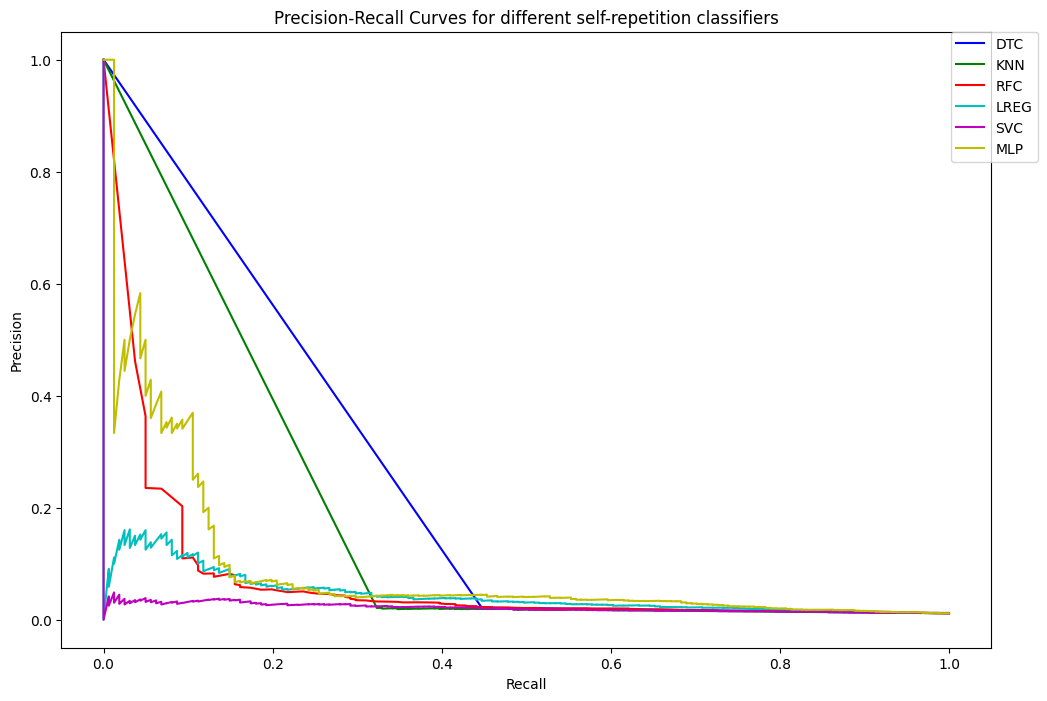

In [54]:
# Now fit the models with their best parameters and feature sets on the train set and test them on the test set:

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve

plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y']
i=0

for model_name, config in model_config.items():
    model_obj = config['model_obj']
    best_features = config['best_feature_set']
    best_params = config['best_params']

    # Set parameters
    model_best = model_obj().set_params(**best_params)

    # Fit the model on training data
    model_best.fit(X_train_total[best_features], y_train)

    # Make predictions
    y_pred = model_best.predict(X_test[best_features])

    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred, pos_label='repetitive')
    test_precision = precision_score(y_test, y_pred, pos_label='repetitive')
    test_f1 = f1_score(y_test, y_pred, pos_label='repetitive')

    # Store metrics in the dictionary
    model_config[model_name]['test_accuracy'] = test_accuracy
    model_config[model_name]['test_recall'] = test_recall
    model_config[model_name]['test_precision'] = test_precision
    model_config[model_name]['test_f1'] = test_f1
    print(model_config[model_name], '\n')

    # Calculate precision-recall curve
    precision, recall, threshold = precision_recall_curve(y_test, model_best.predict_proba(X_test[best_features])[:, 1], pos_label='repetitive')

    # Plot precision-recall curve
    plt.plot(recall, precision, color=colors[i], label=model_name)
    i+=1

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for different self-repetition classifiers')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.savefig('Visualisations/Precision_recall_selfrep.png')  
plt.show()

        

In [55]:
import pickle
with open('Model_config_selfrep', 'wb') as handle:
    pickle.dump(model_config, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
for model, items in model_config.items():
    print('\n',model)
    for key, value in items.items():
        print(key,': ', value)


 DTC
model_obj :  <class 'sklearn.tree._classes.DecisionTreeClassifier'>
best_feature_set :  ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc']
best_k_features :  ['DTW_mfcc' 'DTW_mfcc_lpc']
best_params :  {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_avg_val_f1 :  0.807126606022802
test_accuracy :  0.7618809046664758
test_recall :  0.4472049689440994
test_precision :  0.02175226586102719
test_f1 :  0.04148660328435609

 KNN
model_obj :  <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
best_feature_set :  ['DTW_mfcc', 'DTW_melspectrogram', 'DTW_lpc', 'DTW_combined', 'DTW_mfcc_melspectrogram', 'DTW_mfcc_lpc', 'DTW_melspectrogram_lpc']
best_k_features :  ['DTW_mfcc' 'DTW_mfcc_lpc']
best_params :  {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
best_avg_val_f1 :  0.9159182898471134
test_accuracy :  0.7075579730890352
test_rec

# Get best threshold for best model and store trained model

In [31]:
# Get precision, recall and F1 for different thresholds for the best classifier (Logistic Regression)

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve


config= model_config['LREG']
model_obj = config['model_obj']
best_features = config['best_feature_set']
best_params = config['best_params']

# Set parameters
model_best = model_obj().set_params(**best_params)

# Fit the model on training data
model_best.fit(X_train_total[best_features], y_train)


# Calculate precision-recall curve
precision, recall, threshold = precision_recall_curve(y_test, model_best.predict_proba(X_test[best_features])[:, 1], pos_label='repetitive')

# Store data in dataframe
df= pd.DataFrame(columns= ['Precision','Recall','F1','Threshold'])
i=0
for pr, rec, thr in zip(precision, recall, threshold):
    f1= 2*pr*rec/(pr+rec)
    df.loc[i]= [pr, rec, f1, thr]
    i+=1

In [32]:
df.loc[df['Precision']== df['Precision'].max()] # Maximum value for precision

,Precision,Recall,F1,Threshold
13941,0.16129,0.031056,0.052083,0.885098


In [33]:
df.loc[df['Recall']== df['Recall'].max()] # Maximum value for recall

,Precision,Recall,F1,Threshold
0,0.011523,1.0,0.022784,0.006358
1,0.011524,1.0,0.022785,0.007583
2,0.011525,1.0,0.022787,0.010448
3,0.011526,1.0,0.022788,0.010464
4,0.011526,1.0,0.022790,0.013961
...,...,...,...,...
667,0.012101,1.0,0.023912,0.130645
668,0.012102,1.0,0.023914,0.130663
669,0.012103,1.0,0.023916,0.130711
670,0.012103,1.0,0.023917,0.130739


In [34]:
df.loc[df['F1']== df['F1'].max()] # Maximum value for F1-score

,Precision,Recall,F1,Threshold
13822,0.12,0.111801,0.115756,0.833329


In [43]:
max_f1= df.loc[(df['Recall']> 0.15) & (df['Precision']> 0.08), ['F1']].max() # Get max F1 score with acceptable precision and recall

In [50]:
df.loc[(df['Recall']> 0.15) & (df['Precision']> 0.08) & (df['F1']== max_f1[0])]

,Precision,Recall,F1,Threshold
13654,0.081761,0.161491,0.108559,0.796943


In [51]:
threshold= float(df.loc[(df['Recall']> 0.15) & (df['Precision']> 0.08) & (df['F1']== max_f1[0]), 'Threshold'])

In [52]:
threshold

0.79694346981021

In [53]:
# Store trained model and configurations
model_best.fit(X_train_total[best_features], y_train)
best_model_config= {'model_obj': model_best, 'best_features': best_features, 'threshold': threshold}
with open('Trained_best_classifier_self-repetition.pkl', 'wb') as handle:
    pickle.dump(best_model_config, handle, protocol=pickle.HIGHEST_PROTOCOL)